In [1]:
!pip install -qU codecarbon
!pip install -qU onnx
!pip install -qU onnxruntime
!pip install -q -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.7/516.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 8.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.4.0 requires httpx<1.0.0dev,>=0.28.1, but you have httpx 0.27.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer, AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup, BitsAndBytesConfig
)
import torch.nn as nn
import tensorflow as tf
from tqdm import tqdm
from codecarbon import EmissionsTracker
import onnx
import onnxruntime as ort
from sklearn.metrics import f1_score, precision_score, recall_score
import time

In [3]:
arxiv_data = pd.read_csv('/content/arxiv_data.csv')
arxiv_data

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"
...,...,...,...
51766,Hierarchically-coupled hidden Markov models fo...,We address the problem of analyzing sets of no...,"['stat.ML', 'physics.bio-ph', 'q-bio.QM']"
51767,Blinking Molecule Tracking,We discuss a method for tracking individual mo...,"['cs.CV', 'cs.DM']"
51768,Towards a Mathematical Foundation of Immunolog...,We attempt to set a mathematical foundation of...,"['stat.ML', 'cs.LG', 'q-bio.GN']"
51769,A Semi-Automatic Graph-Based Approach for Dete...,Diffusion Tensor Imaging (DTI) allows estimati...,['cs.CV']


In [4]:
arxiv_data.shape

(51771, 3)

In [5]:
labels_column = arxiv_data['terms'].apply(literal_eval)
labels = labels_column.explode().unique()
print(labels)
print(len(labels))

['cs.CV' 'cs.LG' 'cs.AI' ... 'I.2.6; I.5.1; G.3'
 '92E10, 46M20, 94A08, 68U10, 44A12, 55R35' '92E10']
1099


In [6]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

There are 38970 rows in the deduplicated dataset.
2320
3156


In [7]:
# Filtering the rare terms.
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36650, 3)

In [8]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

In [9]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1832
Number of rows in test set: 1833


In [10]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.CG', 'cs.SE', 'cs.NI', 'I.2.6', 'stat.CO', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.LO', 'cs.PL', 'cond-mat.dis-nn', '68T45', 'math.PR', 'physics.comp-ph', 'cs.CE', 'cs.AR', 'I.2.10', 'q-fin.ST', 'cond-mat.stat-mech', '68T05', 'quant-ph', 'math.DS', 'cs.CC', 'I.4.6', 'physics.data-an', 'physics.soc-ph', 'physics.ao-ph', 'cs.DM', 'q-bio.GN', 'econ.EM', 'physics.med-ph', 'astro-ph.IM', 'I.4.8', 'math.AT', 'cs.PF', 'I.4', 'q-fin.TR', 'cs.FL', 'I.5.4', 'I.2', '68U10', 'physics.geo-ph', 'hep-ex', 'cond-mat.mtrl-sci', '68T10', 'physics.optics', 'q-fin.CP', 'physics.flu-dyn', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6; I.2.8', '

In [11]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.LG', 'cs.AI', 'stat.ML']
Label-binarized representation: [[0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]]


In [12]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()

,summaries
count,32985.000000
mean,156.400455
std,41.491150
min,1.000000
25%,128.000000
50%,154.000000
75%,183.000000
max,462.000000


In [13]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [14]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [15]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'Data augmentation (DA) plays a critical role in training deep neural networks\nfor improving the generalization of models. Recent work has shown that\nautomatic DA policy, such as AutoAugment (AA), significantly improves model\nperformance. However, most automatic DA methods search for DA policies at the\nimage-level without considering that the optimal policies for different regions\nin an image may be diverse. In this paper, we propose a patch-level automatic\nDA algorithm called Patch AutoAugment (PAA). PAA divides an image into a grid\nof patches and searches for the optimal DA policy of each patch. Specifically,\nPAA allows each patch DA operation to be controlled by an agent and models it\nas a Multi-Agent Reinforcement Learning (MARL) problem. At each step, PAA\nsamples the most effective operation for each patch based on its content and\nthe semantics of the whole image. The agents cooperate as a team and share a\nunified team reward for achieving the joint optimal 

In [16]:
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

153342


In [17]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Hyperparameters
MAX_LEN = 150
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
MODEL_TYPES = ["bert-base-uncased", "distilbert-base-uncased", "google/bert_uncased_L-2_H-128_A-2"]
MODEL_NAMES = ["BERT-Quantized", "DistilBERT-Quantized", "TinyBERT-Quantized"]

In [18]:
# Custom dataset class
class ArxivDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

In [19]:
class QuantizedBERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels, device):
        super(QuantizedBERTClassifier, self).__init__()

        # Use a simpler quantization approach - load model in FP16 precision
        self.device = device
        self.dtype = torch.float16  # Explicitly define the dtype

        if 'distilbert' in model_name:
            self.bert = AutoModel.from_pretrained(
                model_name,
                torch_dtype=self.dtype
            ).to(self.device)
            self.dropout = nn.Dropout(0.1).to(self.device)
            # Ensure the classifier uses the same dtype
            self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels).to(self.device).to(self.dtype)
        elif 'google/bert' in model_name:  # TinyBERT
            self.bert = AutoModel.from_pretrained(
                model_name,
                torch_dtype=self.dtype
            ).to(self.device)
            self.dropout = nn.Dropout(0.1).to(self.device)
            # Ensure the classifier uses the same dtype
            self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels).to(self.device).to(self.dtype)
        else:  # Regular BERT
            self.bert = AutoModel.from_pretrained(
                model_name,
                torch_dtype=self.dtype
            ).to(self.device)
            self.dropout = nn.Dropout(0.1).to(self.device)
            # Ensure the classifier uses the same dtype
            self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels).to(self.device).to(self.dtype)

    def forward(self, input_ids, attention_mask):
        # Ensure inputs are on the correct device and dtype
        input_ids = input_ids.to(self.device)
        attention_mask = attention_mask.to(self.device)

        # Using the unified AutoModel interface for all model types
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Get the appropriate pooled output depending on model type
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            pooled_output = outputs.pooler_output
        else:
            # For models without pooler_output, use the [CLS] token representation
            pooled_output = outputs.last_hidden_state[:, 0]

        x = self.dropout(pooled_output)
        logits = self.classifier(x)
        return logits

In [20]:
# Training function
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, device, model_save_path):
    best_val_loss = float('inf')
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        # Training
        model.train()
        train_loss = 0
        train_progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}')

        for batch in train_progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            train_progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{EPOCHS}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')

    return train_losses, val_losses

In [21]:
# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    criterion = nn.BCEWithLogitsLoss()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            preds = torch.sigmoid(outputs).cpu().detach().numpy()
            preds = (preds > 0.5).astype(int)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average='micro')
    precision = precision_score(all_labels, all_preds, average='micro')
    recall = recall_score(all_labels, all_preds, average='micro')

    avg_loss = total_loss / len(dataloader)

    return {
        'loss': avg_loss,
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [22]:
def export_to_onnx(model, tokenizer, onnx_path, device):
    model.eval()

    # Create dummy input
    dummy_input = tokenizer(
        "This is a dummy input for ONNX export",
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # Move tensors to the same device as the model
    input_ids = dummy_input['input_ids'].to(device)
    attention_mask = dummy_input['attention_mask'].to(device)

    # Export to ONNX using opset version 14 instead of 11
    torch.onnx.export(
        model,
        (input_ids, attention_mask),
        onnx_path,
        export_params=True,
        opset_version=14,  # Updated from 11 to 14
        do_constant_folding=True,
        input_names=['input_ids', 'attention_mask'],
        output_names=['output'],
        dynamic_axes={
            'input_ids': {0: 'batch_size'},
            'attention_mask': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )

    # Verify the ONNX model
    onnx_model = onnx.load(onnx_path)
    onnx.checker.check_model(onnx_model)

    print(f"Model successfully exported to {onnx_path}")

    return onnx_path

In [23]:
# Create label encoding mappings
def create_label_mappings(all_terms):
    # Flatten the list of lists
    all_terms_flat = []
    for terms in all_terms:
        all_terms_flat.extend(terms)

    # Get unique terms
    unique_terms = sorted(set(all_terms_flat))

    # Create mappings
    label2idx = {term: idx for idx, term in enumerate(unique_terms)}
    idx2label = {idx: term for term, idx in label2idx.items()}

    return label2idx, idx2label, len(unique_terms)

# Create one-hot encoded labels
def encode_labels(terms, label2idx):
    encoded = [0] * len(label2idx)
    for term in terms:
        if term in label2idx:
            encoded[label2idx[term]] = 1
    return encoded

In [24]:
# Create emissions directory if it doesn't exist
if not os.path.exists("emissions"):
    os.makedirs("emissions")
    print("Created emissions directory")

Created emissions directory


In [25]:
def run_pipeline(model_type, model_name):
    # Check if CUDA is available else use CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize tokenizer using AutoTokenizer for all model types
    tokenizer = AutoTokenizer.from_pretrained(model_type, use_fast=True)

    # Ensure all tokenizers have padding token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token if tokenizer.eos_token is not None else tokenizer.cls_token

    # Prepare datasets
    train_labels = [encode_labels(terms, label2idx) for terms in train_df['terms']]
    val_labels = [encode_labels(terms, label2idx) for terms in val_df['terms']]
    test_labels = [encode_labels(terms, label2idx) for terms in test_df['terms']]

    train_dataset = ArxivDataset(train_df['summaries'].values, train_labels, tokenizer, MAX_LEN)
    val_dataset = ArxivDataset(val_df['summaries'].values, val_labels, tokenizer, MAX_LEN)
    test_dataset = ArxivDataset(test_df['summaries'].values, test_labels, tokenizer, MAX_LEN)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Initialize model using our quantized model class, passing device
    start_time = time.time()
    print(f"Loading model in half precision (FP16): {model_type}")

    model = QuantizedBERTClassifier(model_type, num_labels, device)

    end_time = time.time()
    print(f"Model loaded in {end_time - start_time:.2f} seconds")

    # Initialize optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_dataloader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Track carbon emissions
    tracker = EmissionsTracker(project_name=f"{model_name}_training", output_dir="emissions")
    tracker.start()

    # Train model
    model_save_path = f"{model_name}_model.pt"
    train_losses, val_losses = train_model(
        model, train_dataloader, val_dataloader,
        optimizer, scheduler, device, model_save_path
    )

    # Stop tracking emissions
    emissions = tracker.stop()
    print(f"Carbon emissions: {emissions} kg CO2eq")

    # Load best model
    model.load_state_dict(torch.load(model_save_path))

    # Evaluate on test set
    test_metrics = evaluate_model(model, test_dataloader, device)
    print(f"Test metrics for {model_name}:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Export to ONNX
    onnx_path = f"{model_name}_model.onnx"
    export_to_onnx(model, tokenizer, onnx_path, device)

    return {
        'model_name': model_name,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_metrics': test_metrics,
        'emissions': emissions
    }

# Ensure we have the label mappings before running the pipeline
label2idx, idx2label, num_labels = create_label_mappings(train_df['terms'].values)
print(f"Number of unique labels: {num_labels}")

# Run the pipeline for each model type
results = []
for model_type, model_name in zip(MODEL_TYPES, MODEL_NAMES):
    print(f"\n{'='*50}")
    print(f"Training {model_name} model")
    print(f"{'='*50}\n")

    result = run_pipeline(model_type, model_name)
    results.append(result)

Number of unique labels: 152

Training BERT-Quantized model

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Loading model in half precision (FP16): bert-base-uncased


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[codecarbon INFO @ 17:25:02] [setup] RAM Tracking...
[codecarbon INFO @ 17:25:02] [setup] CPU Tracking...
[codecarbon WARNING @ 17:25:02] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



Model loaded in 18.75 seconds


[codecarbon WARNING @ 17:25:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 17:25:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 17:25:04] [setup] GPU Tracking...
[codecarbon INFO @ 17:25:04] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:25:04] >>> Tracker's metadata:
[codecarbon INFO @ 17:25:04]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 17:25:04]   Python version: 3.11.11
[codecarbon INFO @ 17:25:04]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 17:25:04]   Available RAM : 12.675 GB
[codecarbon INFO @ 17:25:04]   CPU count: 2
[codecarbon INFO @ 17:25:04]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 17:25:04]   GPU count: 1
[codecarbon INFO @ 17:25:04]   GPU model: 1 x Tesla T4
[codecarbon INFO @ 17:25:04] Saving emissions data to file /content/emissions/emissions.csv
Epoch 1/3:   5%|▍         | 47/1031 [00:14<04:

Epoch 1/3:
Training Loss: 0.0332
Validation Loss: 0.0297
Model saved to BERT-Quantized_model.pt


Epoch 2/3:   4%|▍         | 39/1031 [00:07<03:11,  5.19it/s, training_loss=0.035][codecarbon INFO @ 17:28:49] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 17:28:49] Energy consumed for all CPUs : 0.002655 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:28:49] Energy consumed for all GPUs : 0.004091 kWh. Total GPU Power : 64.39245899515888 W
[codecarbon INFO @ 17:28:49] 0.007043 kWh of electricity used since the beginning.
Epoch 2/3:  11%|█         | 114/1031 [00:22<03:05,  4.95it/s, training_loss=0.030][codecarbon INFO @ 17:29:04] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 17:29:04] Energy consumed for all CPUs : 0.002832 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:29:04] Energy consumed for all GPUs : 0.004369 kWh. Total GPU Power : 66.72895493736571 W
Epoch 2/3:  18%|█▊        | 189/1031 [00:37<02:47,  5.03it/s, training_loss=0.029][codecarbon INFO @ 17:29:19] Energy consumed f

Epoch 2/3:
Training Loss: 0.0294
Validation Loss: 0.0287
Model saved to BERT-Quantized_model.pt


Epoch 3/3:   4%|▎         | 38/1031 [00:07<03:13,  5.13it/s, training_loss=0.028][codecarbon INFO @ 17:32:19] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 17:32:19] Energy consumed for all CPUs : 0.005133 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:32:19] Energy consumed for all GPUs : 0.007977 kWh. Total GPU Power : 64.35565070137372 W
[codecarbon INFO @ 17:32:19] 0.013683 kWh of electricity used since the beginning.
Epoch 3/3:  11%|█         | 112/1031 [00:22<03:19,  4.60it/s, training_loss=0.035][codecarbon INFO @ 17:32:34] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 17:32:34] Energy consumed for all CPUs : 0.005310 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:32:34] Energy consumed for all GPUs : 0.008254 kWh. Total GPU Power : 66.65817576906421 W
[codecarbon INFO @ 17:32:34] 0.014158 kWh of electricity used since the beginning.
Epoch 3/3:  18%|█▊        | 188/1031 [00:37<0

Epoch 3/3:
Training Loss: 0.0282
Validation Loss: 0.0270


[codecarbon INFO @ 17:35:42] Energy consumed for RAM : 0.000842 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 17:35:42] Energy consumed for all CPUs : 0.007527 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:35:42] Energy consumed for all GPUs : 0.011733 kWh. Total GPU Power : 62.10143843954375 W
[codecarbon INFO @ 17:35:42] 0.020101 kWh of electricity used since the beginning.


Model saved to BERT-Quantized_model.pt
Carbon emissions: 0.009463302355289591 kg CO2eq


/usr/local/lib/python3.11/dist-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])
<ipython-input-25-5a464f72986e>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects wil

Test metrics for BERT-Quantized:
loss: 0.0265
accuracy: 0.9894
f1: 0.5846
precision: 0.5674
recall: 0.6029
Model successfully exported to BERT-Quantized_model.onnx

Training DistilBERT-Quantized model

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Loading model in half precision (FP16): distilbert-base-uncased


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[codecarbon INFO @ 17:35:59] [setup] RAM Tracking...
[codecarbon INFO @ 17:35:59] [setup] CPU Tracking...
[codecarbon WARNING @ 17:35:59] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



Model loaded in 2.16 seconds


[codecarbon WARNING @ 17:36:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 17:36:00] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 17:36:00] [setup] GPU Tracking...
[codecarbon INFO @ 17:36:00] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:36:00] >>> Tracker's metadata:
[codecarbon INFO @ 17:36:00]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 17:36:00]   Python version: 3.11.11
[codecarbon INFO @ 17:36:00]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 17:36:00]   Available RAM : 12.675 GB
[codecarbon INFO @ 17:36:00]   CPU count: 2
[codecarbon INFO @ 17:36:00]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 17:36:00]   GPU count: 1
[codecarbon INFO @ 17:36:00]   GPU model: 1 x Tesla T4
[codecarbon INFO @ 17:36:00] Saving emissions data to file /content/emissions/emissions.csv
Epoch 1/3:  12%|█▏        | 125/1031 [00:14<02

Epoch 1/3:
Training Loss: 0.0307
Validation Loss: 0.0282
Model saved to DistilBERT-Quantized_model.pt


Epoch 2/3:   8%|▊         | 85/1031 [00:10<01:46,  8.84it/s, training_loss=0.022][codecarbon INFO @ 17:38:15] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 17:38:15] Energy consumed for all CPUs : 0.001593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:38:15] Energy consumed for all GPUs : 0.002434 kWh. Total GPU Power : 62.539667023126825 W
[codecarbon INFO @ 17:38:15] 0.004205 kWh of electricity used since the beginning.
Epoch 2/3:  21%|██        | 214/1031 [00:25<01:31,  8.97it/s, training_loss=0.021][codecarbon INFO @ 17:38:30] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 17:38:30] Energy consumed for all CPUs : 0.001770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:38:30] Energy consumed for all GPUs : 0.002707 kWh. Total GPU Power : 65.67413009922268 W
[codecarbon INFO @ 17:38:30] 0.004676 kWh of electricity used since the beginning.
Epoch 2/3:  33%|███▎      | 339/1031 [00:40<

Epoch 2/3:
Training Loss: 0.0283
Validation Loss: 0.0275
Model saved to DistilBERT-Quantized_model.pt


Epoch 3/3:   5%|▍         | 47/1031 [00:05<01:54,  8.56it/s, training_loss=0.035][codecarbon INFO @ 17:40:15] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 17:40:15] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:40:15] Energy consumed for all GPUs : 0.004602 kWh. Total GPU Power : 63.37322494307703 W
[codecarbon INFO @ 17:40:15] 0.007948 kWh of electricity used since the beginning.
Epoch 3/3:  17%|█▋        | 176/1031 [00:20<01:40,  8.52it/s, training_loss=0.032][codecarbon INFO @ 17:40:30] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 17:40:30] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:40:30] Energy consumed for all GPUs : 0.004874 kWh. Total GPU Power : 65.34791094980356 W
[codecarbon INFO @ 17:40:30] 0.008417 kWh of electricity used since the beginning.
Epoch 3/3:  30%|██▉       | 306/1031 [00:35<0

Epoch 3/3:
Training Loss: 0.0278
Validation Loss: 0.0272


[codecarbon INFO @ 17:42:14] Energy consumed for RAM : 0.000493 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 17:42:14] Energy consumed for all CPUs : 0.004411 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:42:14] Energy consumed for all GPUs : 0.006747 kWh. Total GPU Power : 62.69193426878335 W
[codecarbon INFO @ 17:42:14] 0.011651 kWh of electricity used since the beginning.
<ipython-input-25-5a464f72986e>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mod

Model saved to DistilBERT-Quantized_model.pt
Carbon emissions: 0.005485273558814551 kg CO2eq


Evaluating: 100%|██████████| 58/58 [00:03<00:00, 14.54it/s]


Test metrics for DistilBERT-Quantized:
loss: 0.0266
accuracy: 0.9894
f1: 0.5846
precision: 0.5674
recall: 0.6029
Model successfully exported to DistilBERT-Quantized_model.onnx

Training TinyBERT-Quantized model

Using device: cuda


config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Loading model in half precision (FP16): google/bert_uncased_L-2_H-128_A-2


model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[codecarbon INFO @ 17:42:25] [setup] RAM Tracking...
[codecarbon INFO @ 17:42:25] [setup] CPU Tracking...
[codecarbon WARNING @ 17:42:25] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



Model loaded in 1.01 seconds


[codecarbon WARNING @ 17:42:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 17:42:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 17:42:26] [setup] GPU Tracking...
[codecarbon INFO @ 17:42:26] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:42:26] >>> Tracker's metadata:
[codecarbon INFO @ 17:42:26]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 17:42:26]   Python version: 3.11.11
[codecarbon INFO @ 17:42:26]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 17:42:26]   Available RAM : 12.675 GB
[codecarbon INFO @ 17:42:26]   CPU count: 2
[codecarbon INFO @ 17:42:26]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 17:42:26]   GPU count: 1
[codecarbon INFO @ 17:42:26]   GPU model: 1 x Tesla T4
[codecarbon INFO @ 17:42:27] Saving emissions data to file /content/emissions/emissions.csv
Epoch 1/3:  25%|██▍       | 256/1031 [00:14<00

Epoch 1/3:
Training Loss: 0.0289
Validation Loss: 0.0212
Model saved to TinyBERT-Quantized_model.pt


Epoch 2/3:  25%|██▌       | 259/1031 [00:14<00:59, 12.98it/s, training_loss=0.018][codecarbon INFO @ 17:43:42] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 17:43:42] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:43:42] Energy consumed for all GPUs : 0.000719 kWh. Total GPU Power : 35.31944614083152 W
[codecarbon INFO @ 17:43:42] 0.001703 kWh of electricity used since the beginning.
Epoch 2/3:  51%|█████     | 525/1031 [00:29<00:26, 18.89it/s, training_loss=0.019][codecarbon INFO @ 17:43:57] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 17:43:57] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:43:57] Energy consumed for all GPUs : 0.000866 kWh. Total GPU Power : 35.42629327736498 W
[codecarbon INFO @ 17:43:57] 0.002047 kWh of electricity used since the beginning.
Epoch 2/3:  77%|███████▋  | 797/1031 [00:44<

Epoch 2/3:
Training Loss: 0.0209
Validation Loss: 0.0198
Model saved to TinyBERT-Quantized_model.pt


Epoch 3/3:  26%|██▋       | 272/1031 [00:14<00:39, 19.34it/s, training_loss=0.019][codecarbon INFO @ 17:44:42] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 17:44:42] Energy consumed for all CPUs : 0.001593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:44:42] Energy consumed for all GPUs : 0.001309 kWh. Total GPU Power : 35.334751077720384 W
[codecarbon INFO @ 17:44:42] 0.003080 kWh of electricity used since the beginning.
Epoch 3/3:  52%|█████▏    | 533/1031 [00:29<00:38, 13.06it/s, training_loss=0.021][codecarbon INFO @ 17:44:57] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 17:44:57] Energy consumed for all CPUs : 0.001770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:44:57] Energy consumed for all GPUs : 0.001455 kWh. Total GPU Power : 35.136367498081626 W
[codecarbon INFO @ 17:44:57] 0.003423 kWh of electricity used since the beginning.
Epoch 3/3:  77%|███████▋  | 797/1031 [00:4

Epoch 3/3:
Training Loss: 0.0199
Validation Loss: 0.0192
Model saved to TinyBERT-Quantized_model.pt
Carbon emissions: 0.0019380017509237017 kg CO2eq


Evaluating: 100%|██████████| 58/58 [00:02<00:00, 24.21it/s]


Test metrics for TinyBERT-Quantized:
loss: 0.0185
accuracy: 0.9943
f1: 0.7453
precision: 0.8430
recall: 0.6678
Model successfully exported to TinyBERT-Quantized_model.onnx


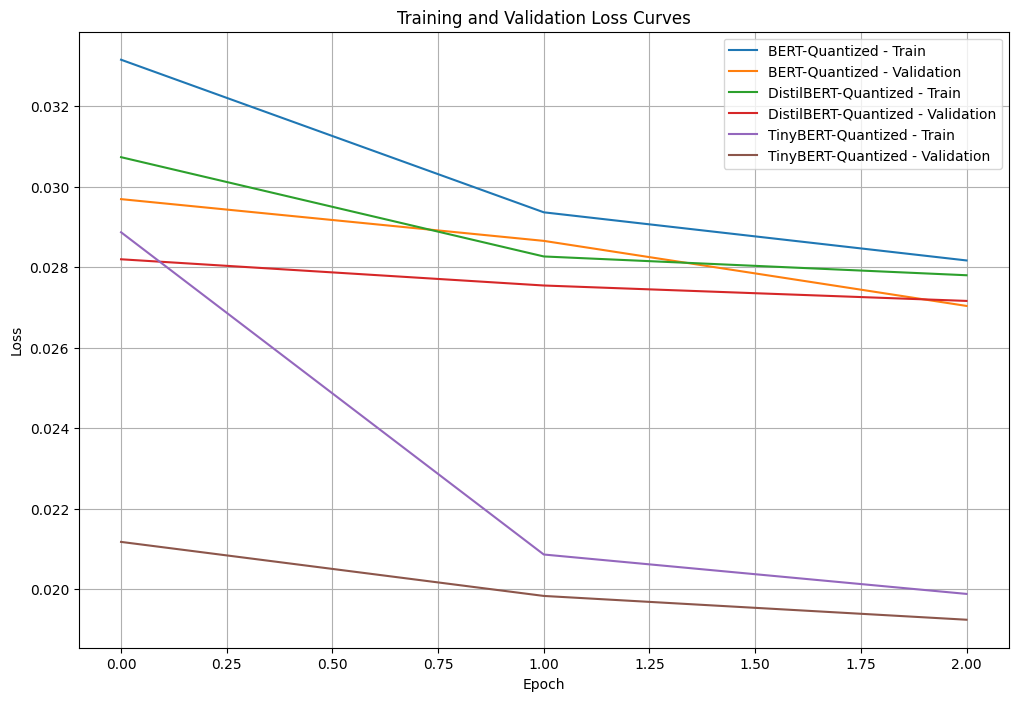

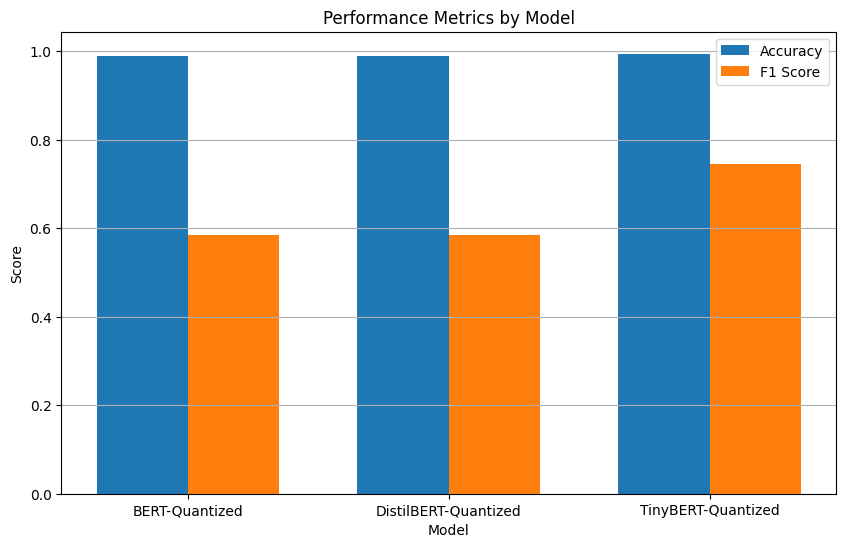

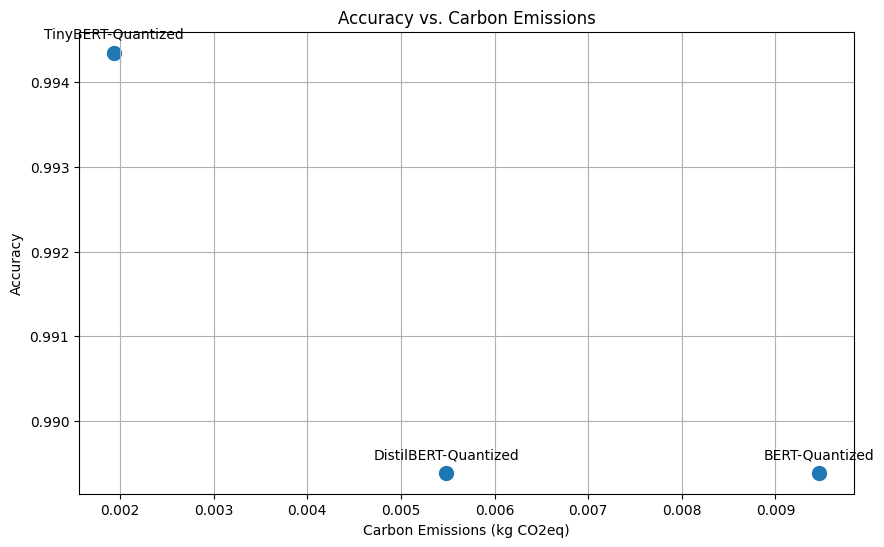

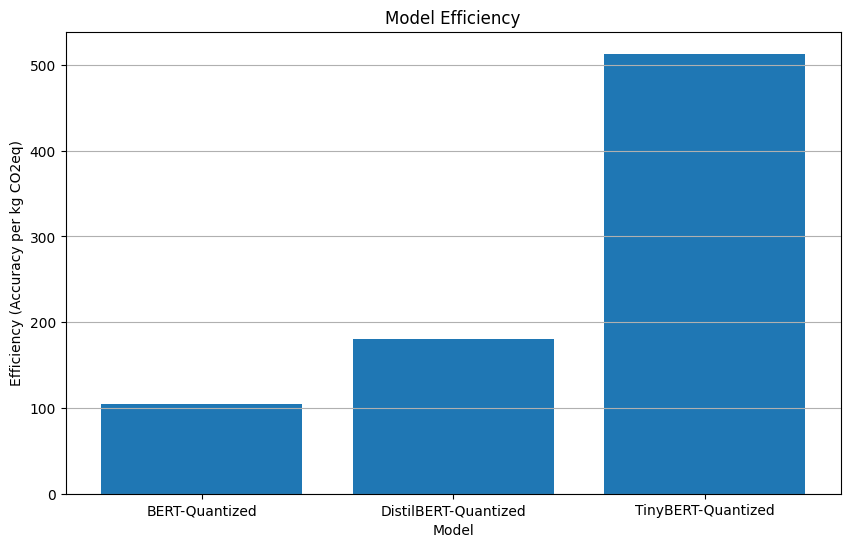

In [26]:
# Visualization functions
def plot_training_curves(results):
    plt.figure(figsize=(12, 8))

    for result in results:
        model_name = result['model_name']
        train_losses = result['train_losses']
        val_losses = result['val_losses']

        plt.plot(train_losses, label=f"{model_name} - Train")
        plt.plot(val_losses, label=f"{model_name} - Validation")

    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curves.png')
    plt.show()

def plot_model_comparison(results):
    model_names = [result['model_name'] for result in results]
    accuracies = [result['test_metrics']['accuracy'] for result in results]
    f1_scores = [result['test_metrics']['f1'] for result in results]
    emissions = [result['emissions'] for result in results]

    # Metrics comparison
    plt.figure(figsize=(10, 6))
    x = np.arange(len(model_names))
    width = 0.35

    plt.bar(x - width/2, accuracies, width, label='Accuracy')
    plt.bar(x + width/2, f1_scores, width, label='F1 Score')

    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Performance Metrics by Model')
    plt.xticks(x, model_names)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('performance_comparison.png')
    plt.show()

    # Accuracy vs Emissions
    plt.figure(figsize=(10, 6))
    plt.scatter(emissions, accuracies, s=100)

    for i, model_name in enumerate(model_names):
        plt.annotate(model_name, (emissions[i], accuracies[i]),
                    textcoords="offset points", xytext=(0,10), ha='center')

    plt.xlabel('Carbon Emissions (kg CO2eq)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Carbon Emissions')
    plt.grid(True)
    plt.savefig('accuracy_vs_emissions.png')
    plt.show()

    # Efficiency metric (accuracy per emission)
    efficiency = [acc/em for acc, em in zip(accuracies, emissions)]

    plt.figure(figsize=(10, 6))
    plt.bar(model_names, efficiency)
    plt.xlabel('Model')
    plt.ylabel('Efficiency (Accuracy per kg CO2eq)')
    plt.title('Model Efficiency')
    plt.grid(True, axis='y')
    plt.savefig('model_efficiency.png')
    plt.show()

# Generate visualizations
plot_training_curves(results)
plot_model_comparison(results)

In [27]:
# Function to perform inference with the ONNX model
def onnx_inference(onnx_path, tokenizer, text, label2idx, idx2label):
    # Create an ONNX Runtime session
    session = ort.InferenceSession(onnx_path)

    # Tokenize the input text
    inputs = tokenizer(
        text,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # Get input names
    input_names = [input.name for input in session.get_inputs()]

    # Create the input feed
    ort_inputs = {
        input_names[0]: inputs['input_ids'].numpy(),
        input_names[1]: inputs['attention_mask'].numpy()
    }

    # Run inference
    outputs = session.run(None, ort_inputs)

    # Process outputs
    logits = outputs[0]
    predictions = (1 / (1 + np.exp(-logits))) > 0.5

    # Get predicted labels
    predicted_labels = []
    for idx, pred in enumerate(predictions[0]):
        if pred:
            predicted_labels.append(idx2label[idx])

    return predicted_labels

# Example of using the ONNX model for inference
example_text = test_df['summaries'].iloc[0]
onnx_path = f"{MODEL_NAMES[0]}_model.onnx"  # Using the BERT model for example
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPES[0])

print("\nExample text for inference:")
print(example_text)

print("\nActual labels:")
print(test_df['terms'].iloc[0])

print("\nPredicted labels (ONNX model):")
predicted_labels = onnx_inference(onnx_path, tokenizer, example_text, label2idx, idx2label)
print(predicted_labels)

# Summary report
print("\n" + "="*80)
print("SUMMARY REPORT")
print("="*80)

print("\nModel Performance:")
for result in results:
    model_name = result['model_name']
    metrics = result['test_metrics']
    emissions = result['emissions']

    print(f"\n{model_name}:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  F1 Score: {metrics['f1']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  Carbon Emissions: {emissions:.6f} kg CO2eq")
    print(f"  Efficiency (Accuracy/Emissions): {metrics['accuracy']/emissions:.6f}")

# Find the most efficient model
efficiency_scores = [result['test_metrics']['accuracy']/result['emissions'] for result in results]
most_efficient_idx = efficiency_scores.index(max(efficiency_scores))
most_accurate_idx = [result['test_metrics']['accuracy'] for result in results].index(
    max([result['test_metrics']['accuracy'] for result in results])
)

print("\nRecommendation:")
print(f"Most Accurate Model: {results[most_accurate_idx]['model_name']}")
print(f"Most Efficient Model: {results[most_efficient_idx]['model_name']}")

if most_efficient_idx != most_accurate_idx:
    acc_diff = results[most_accurate_idx]['test_metrics']['accuracy'] - results[most_efficient_idx]['test_metrics']['accuracy']
    emission_diff = results[most_accurate_idx]['emissions'] - results[most_efficient_idx]['emissions']

    print(f"\nBy choosing {results[most_efficient_idx]['model_name']} over {results[most_accurate_idx]['model_name']}:")
    print(f"  Accuracy trade-off: {acc_diff:.4f} ({acc_diff*100:.2f}%)")
    print(f"  Emission reduction: {emission_diff:.6f} kg CO2eq ({emission_diff/results[most_accurate_idx]['emissions']*100:.2f}%)")


Example text for inference:
Temporal abstraction allows reinforcement learning agents to represent
knowledge and develop strategies over different temporal scales. The
option-critic framework has been demonstrated to learn temporally extended
actions, represented as options, end-to-end in a model-free setting. However,
feasibility of option-critic remains limited due to two major challenges,
multiple options adopting very similar behavior, or a shrinking set of task
relevant options. These occurrences not only void the need for temporal
abstraction, they also affect performance. In this paper, we tackle these
problems by learning a diverse set of options. We introduce an
information-theoretic intrinsic reward, which augments the task reward, as well
as a novel termination objective, in order to encourage behavioral diversity in
the option set. We show empirically that our proposed method is capable of
learning options end-to-end on several discrete and continuous control tasks,
outper